In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import timeit
import imp
import copy
import scipy.io as sci  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time


In [3]:
# TODO - NYU Depth V2:
# The NYU-Depth V2 data set is comprised of video sequences from a variety of
# indoor scenes as recorded by both the RGB and Depth cameras from the Microsoft
# Kinect. It features:
#   - 1449 densely labeled pairs of aligned RGB and depth images
#   - 464 new scenes taken from 3 cities
#   - 407,024 new unlabeled frames
#   - Each object is labeled with a class and an instance number (cup1, cup2, cup3, etc)
# The dataset has several components:
#   - Labeled: A subset of the video data accompanied by dense multi-class labels.
#            This data has also been preprocessed to fill in missing depth labels.
#   - Raw: The raw RGB, depth, and accelerometer data as provided by the Kinect.
# Toolbox: Useful functions for manipulating the data and labels.



def downloader(link, base_path, file_name, zip=False):  
    path = base_path + file_name
    isdir = os.path.isdir(path[:-4])
    if isdir:
        print(file_name[:-4], "folder already exists! Download skipped...\n")
    else:
        isFile = os.path.isfile(path)
        if isFile:
            print(file_name, "already exists! Download skipped...\n")
        else:
            import requests
            r = requests.get(link, stream = True)
            # 1 MB = 1024 * 1024 byte
            CS = 5000*1024*1024
            with open(path, "wb") as file: 
                print(file_name, "download started.")
                for i, block in enumerate(r.iter_content(chunk_size = CS)):
                    # print(".", end = "")
                    # print((i+1)*chunk_size,"MB downloaded...")
                    file.write(block)
                    # if block:
                print("\n" + file_name, "download finished.")

base_path = "./"
nyu_dep_name = "nyu_depth_v2_labeled.mat"
nyu_dep_link = "http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat"

start= timeit.default_timer()
downloader(nyu_dep_link, base_path, nyu_dep_name)

stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60) 


nyu_depth_v2_labeled.mat download started.

nyu_depth_v2_labeled.mat download finished.
Time (min):  4.0465177223000035


In [4]:

base_path = "./"
nyu_dep_name = "nyu_depth_v2_labeled.mat"
nyu_dep_link = "http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat"

nyu_dep_path = base_path + nyu_dep_name

import h5py

f = h5py.File(nyu_dep_path,'r')

nyu_dict = {}
start= timeit.default_timer()
print("Shapes:\n")
for key, value in f.items():
    if key == 'depths' or key == 'images' :
        nyu_dict[key] = np.array(value)
        print("{:18s} {}".format(key+":", nyu_dict[key].shape))
print("\ndataset loaded!\n")
stop = timeit.default_timer()
print('Time (min): ', (stop - start)/60) 

Shapes:

depths:            (1449, 640, 480)
images:            (1449, 3, 640, 480)

dataset loaded!

Time (min):  0.4053366817000021


In [5]:
import os
import torch
import torch.nn as nn
import torchvision.models
import collections
import torch.nn.functional as F
import torchvision.transforms as transforms


In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [7]:
def weights_init(m):
    # Initialize kernel weights with Gaussian distributions
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
        
def conv(in_channels, out_channels, kernel_size):
    padding = (kernel_size-1) // 2
    assert 2*padding == kernel_size-1, "parameters incorrect. kernel={}, padding={}".format(kernel_size, padding)
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size,stride=1,padding=padding,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
        )

def depthwise(in_channels, kernel_size):
    padding = (kernel_size-1) // 2
    assert 2*padding == kernel_size-1, "parameters incorrect. kernel={}, padding={}".format(kernel_size, padding)
    return nn.Sequential(
          nn.Conv2d(in_channels,in_channels,kernel_size,stride=1,padding=padding,bias=False,groups=in_channels),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(inplace=True),
        )

def pointwise(in_channels, out_channels):
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,1,1,0,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
        )



In [8]:
class MobileNet(nn.Module):
    def __init__(self, relu6=True):
        super(MobileNet, self).__init__()

        def relu(relu6):
            if relu6:
                return nn.ReLU6(inplace=True)
            else:
                return nn.ReLU(inplace=True)

        def conv_bn(inp, oup, stride, relu6):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                relu(relu6),
            )

        def conv_dw(inp, oup, stride, relu6):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                relu(relu6),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                relu(relu6),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2, relu6), 
            conv_dw( 32,  64, 1, relu6),
            conv_dw( 64, 128, 2, relu6),
            conv_dw(128, 128, 1, relu6),
            conv_dw(128, 256, 2, relu6),
            conv_dw(256, 256, 1, relu6),
            conv_dw(256, 512, 2, relu6),
            conv_dw(512, 512, 1, relu6),
            conv_dw(512, 512, 1, relu6),
            conv_dw(512, 512, 1, relu6),
            conv_dw(512, 512, 1, relu6),
            conv_dw(512, 512, 1, relu6),
            conv_dw(512, 1024, 2, relu6),
            conv_dw(1024, 1024, 1, relu6),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

print('num parameters:', sum(p.numel() for p in MobileNet().parameters() if p.requires_grad))
print('\n',MobileNet())

num parameters: 4231976

 MobileNet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2

In [9]:
class Depth_Estimator(nn.Module):
    def __init__(self):
        super(Depth_Estimator, self).__init__()
        mobilenet = MobileNet()
        # pretrained
        pretrained_path = '../input/mobilenet-pretrained/mobilenet_model.pth.tar'
        checkpoint = torch.load(pretrained_path)
        state_dict = checkpoint['state_dict']

        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        mobilenet.load_state_dict(new_state_dict)


        for i in range(14):
            setattr( self, 'conv{}'.format(i), mobilenet.model[i])

        # NNconv5
        kernel_size = 5
        self.decode_conv1 = nn.Sequential(
            depthwise(1024, kernel_size),
            pointwise(1024, 512))
        self.decode_conv2 = nn.Sequential(
            depthwise(512, kernel_size),
            pointwise(512, 256))
        self.decode_conv3 = nn.Sequential(
            depthwise(256, kernel_size),
            pointwise(256, 128))
        self.decode_conv4 = nn.Sequential(
            depthwise(128, kernel_size),
            pointwise(128, 64))
        self.decode_conv5 = nn.Sequential(
            depthwise(64, kernel_size),
            pointwise(64, 32))
        self.decode_conv6 = pointwise(32, 1)
        weights_init(self.decode_conv1)
        weights_init(self.decode_conv2)
        weights_init(self.decode_conv3)
        weights_init(self.decode_conv4)
        weights_init(self.decode_conv5)
        weights_init(self.decode_conv6)

    def forward(self, x):
        # encoder and preparing skip connections
        for i in range(14):
            layer = getattr(self, 'conv{}'.format(i))
            x = layer(x)
            # print("{}: {}".format(i, x.size()))
            if i==1:
                x1 = x
            elif i==3:
                x2 = x
            elif i==5:
                x3 = x
                
        # decoder with NNconv5 and additive skip connections
        for i in range(1,6):
            layer = getattr(self, 'decode_conv{}'.format(i))
            x = layer(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            if i==4:
                x = x + x1
            elif i==3:
                x = x + x2
            elif i==2:
                x = x + x3
            # print("{}: {}".format(i, x.size()))
        x = self.decode_conv6(x)
        return x
    
Model_Estimator = Depth_Estimator()
print('\n','num parameters:', sum(p.numel() for p in Model_Estimator.parameters() if p.requires_grad))
print(Model_Estimator)



 num parameters: 3960930
Depth_Estimator(
  (conv0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU6(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1,

In [10]:

len_index = len(nyu_dict['depths'])
list_index = np.arange(len(nyu_dict['depths']))
np.random.seed(0)
np.random.shuffle(list_index)

class preparing_data(torch.utils.data.Dataset):
    def __init__(self, subset: str , index = list_index ,root = '../input/nyu-depth-v2/nyu_data' ):
        
        self.root = root
        self.transform_test = transforms.Compose([transforms.CenterCrop(336),transforms.Resize(224)])
        self.subset = subset

        
        len_ = len(index)
        
        if subset == "train":
            self.index = index[:int(len_ * 0.8)]
                
        elif subset == "validation":
            self.index = index[int(len_ * 0.8):int(len_ * 0.95)]
        
        elif  subset == "test":
            self.index = index[int(len_ * 0.95):]
    
                
        else :
            raise ValueError(f"Unknown subset {subset}. Use validation/testing/training")
            
    def train_transform(self, data_, depth_):
        
        transform = transforms.Compose([
            transforms.RandomRotation (0.5), # random rotation degrees
            transforms.CenterCrop(336),
            transforms.RandomHorizontalFlip(p=0.5),# random horizontal flip
            transforms.Resize(224),
        ])
        data_ = transform(data_)
        #data_ = transforms.ColorJitter(0.4, 0.4, 0.4)(data_)
        data_ = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])(data_ / 255)
        return  data_ , transform(depth_)
    
    def test_transform(self, data_, label_):
        # perform 1st step of data augmentation
        data_ = self.transform_test(data_)
        data_ = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])(data_ / 255)
        return  data_ , self.transform_test(label_)

    def __len__(self):
        return len(self.index)
    
    def __getitem__(self,n):
        data = torch.tensor((nyu_dict['images'][self.index[n]].transpose((0,2,1))),dtype = torch.float32)
        label = torch.tensor((nyu_dict['depths'][self.index[n]].transpose((1, 0))),dtype = torch.float32)[None, :]
        if self.subset == 'train' :
            data, label  = self.train_transform(data, label)
        else :
            data, label  = self.test_transform(data, label)

        return data, label

In [11]:
def loss_validation(net, data_loader, device):
    net.eval()
    los = 0
    k = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        k += 1
        los +=nn.MSELoss()(output, target)
        #los += nn.L1Loss()(output, target)
    return np.round(los.cpu().detach().numpy() / k , 4) 

def train_epoch(model, optimizer, train_loader, device):
    model.train()
    losses = 0
    k = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        k += 1
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss =nn.MSELoss()(output, target)
        #loss = nn.L1Loss()(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss

    print(f"Train Loss: {losses.item() / k:.4f}")

    return losses / k

def run(model, train_loader, validation_loader, test_loader, optimizer, scheduler, device, checkpoint_file, n_epoch=10):
    best_score = 100000
    best_model = copy.deepcopy(model)
    
    train_loss = []
    val_loss = []
    
    for epoch in range(n_epoch):
        print('\n',f"--- start epoch {epoch+1} ---")
        train_loss.append(train_epoch(model, optimizer, train_loader, device))
        if scheduler:
            scheduler.step()
        val_loss.append(loss_validation(model, validation_loader, device))
        print(f"Validation_loss: {val_loss[-1]:.5f}")
        if best_score > val_loss[-1]:
            best_score =  val_loss[-1]
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), checkpoint_file)
    print('\n','************','\n',f"best validation_loss: {best_score:.5f}")
    test_loss = loss_validation(best_model, test_loader, device)
    print(f"best Test_loss: {test_loss:.5f}")
    
    return train_loss, val_loss, test_loss


In [12]:
# norm 1 and loss norm 1
checkpoint_file = "best_model3"
batch_size = 8 # 8
epoch = 100 

optimizer = 'sgd' # or adam

# train

if os.path.exists(checkpoint_file):
    raise FileExistsError(f"{checkpoint_file} already exists")

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

print(f"Device: {device}")

model = Depth_Estimator().to(device)

train_loader = torch.utils.data.DataLoader(
    preparing_data(subset="train"),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)
validation_loader = torch.utils.data.DataLoader(
    preparing_data(subset="validation"),
    batch_size=2,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)
test_loader = torch.utils.data.DataLoader(
    preparing_data(subset="test"),
    batch_size=2,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

if optimizer == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
elif optimizer == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
else:
    raise ValueError(f"Unknown optimizer {optimizer}, use adam/sgd")
    
start = timeit.default_timer()
train_loss, val_loss, test_loss = run(model,train_loader,validation_loader,test_loader,
                                      optimizer,scheduler,device,checkpoint_file,n_epoch=epoch)


print('\n','total Time (min) : ', round((timeit.default_timer()-start)/60, 3))

Device: cuda

 --- start epoch 1 ---
Train Loss: 2.2515
Validation_loss: 1.52130

 --- start epoch 2 ---
Train Loss: 1.4397
Validation_loss: 1.24310

 --- start epoch 3 ---
Train Loss: 1.2720
Validation_loss: 1.26460

 --- start epoch 4 ---
Train Loss: 1.2048
Validation_loss: 1.11360

 --- start epoch 5 ---
Train Loss: 1.1379
Validation_loss: 1.53200

 --- start epoch 6 ---
Train Loss: 1.0682
Validation_loss: 1.06870

 --- start epoch 7 ---
Train Loss: 1.0541
Validation_loss: 1.06070

 --- start epoch 8 ---
Train Loss: 0.9978
Validation_loss: 1.07540

 --- start epoch 9 ---
Train Loss: 0.9618
Validation_loss: 1.02090

 --- start epoch 10 ---
Train Loss: 0.9134
Validation_loss: 1.00410

 --- start epoch 11 ---
Train Loss: 0.8502
Validation_loss: 0.93490

 --- start epoch 12 ---
Train Loss: 0.7710
Validation_loss: 0.93280

 --- start epoch 13 ---
Train Loss: 0.7898
Validation_loss: 0.89990

 --- start epoch 14 ---
Train Loss: 0.7659
Validation_loss: 0.92290

 --- start epoch 15 ---
Train

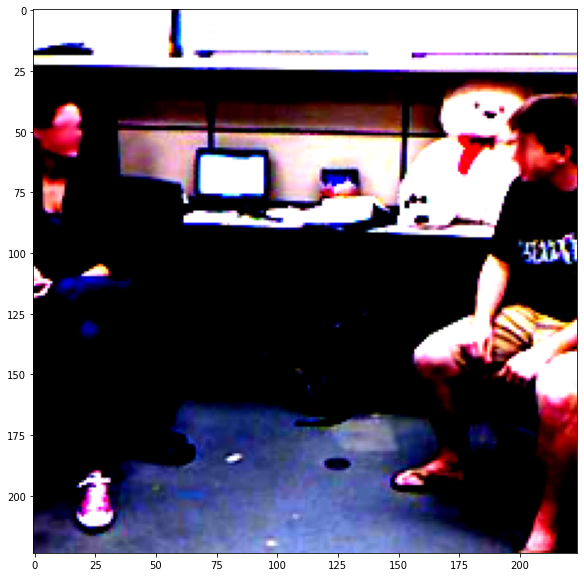

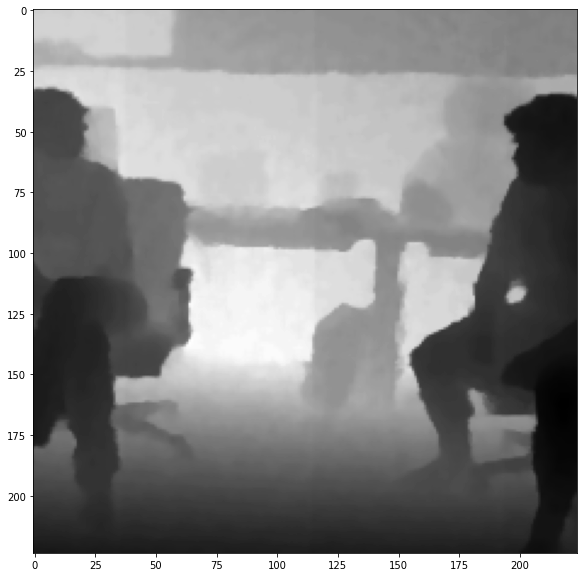

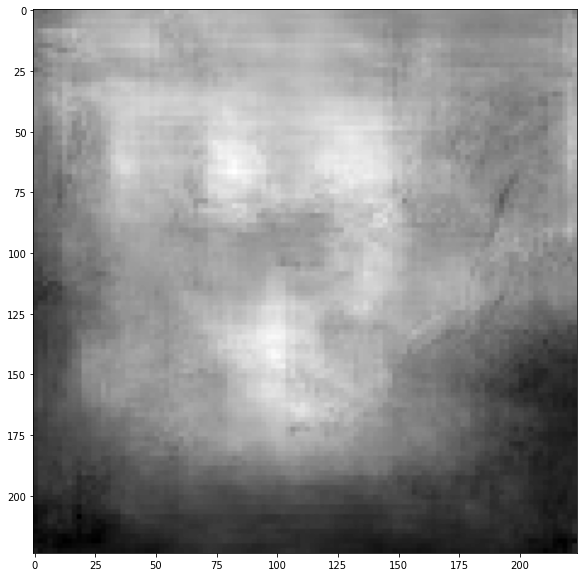

In [13]:
test_data = preparing_data(subset="test")

output = model((test_data[0][0])[None,:].to(device))

plt.figure(figsize = (10,10))
plt.imshow(test_data[0][0].cpu().numpy().transpose((1,2,0)))

plt.figure(figsize = (10,10))
plt.imshow(test_data[0][1].cpu().numpy().squeeze(),cmap = 'gray')

plt.figure(figsize = (10,10))
plt.imshow(output.cpu().detach().numpy().squeeze(),cmap = 'gray')